# RV calculation at Observation Times.

To determine the expected RV shifts of the spectral lines seen my stellar subracted spectra.

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

from PyAstronomy import pyasl   # for doppler shift
import sys
#sys.path.append('/home/jneal/azores/planet/rvs/exonailer/utilities')
try: 
    #import ajplanet
    from ajplanet import pl_rv_array
except:
    pass
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Rodrigo Diaz's true anomaly calculation
def trueanomaly(ma, ecc, niterationmax=10000):
    """
    Compute the true anomaly using the Newton-Raphson method.

    :param array-like ma: mean anomaly.
    :param float ecc: orbital eccentricity.
    :param int niterationmax: maximum number of iterations for N-R method.
    """
    
    if not isinstance(ma, float):
        ea = ma
    else:
        ea = np.array([ma,])

    # Initialise at ea0 = ma
    niteration = 0
    ea0 = ma
    
    while np.linalg.norm(ea - ea0, ord=1) > 1e-5 or niteration==0:
        ea0 = ea
 
        ff = ea - ecc*np.sin(ea) - ma   # Function
        dff = 1 - ecc*np.cos(ea)        # Derivative

        # Use Newton method
        ea = ea0 - ff / dff

        # Increase iteration number; if above limit, break with exception.
        niteration += 1
        if niteration >= niterationmax:
            raise RuntimeError('Eccentric anomaly computation'
                               'not converged.')
        
    # Compute true anomaly from eccentric anomaly
    return 2. * np.arctan2(np.sqrt(1. + ecc) * np.sin(ea/2.),
                           np.sqrt(1. - ecc) * np.cos(ea/2.))

# Mean Anomaly calculation
def meananomaly(t, T0, P):
    """ Calculate mean Anomaly using period, tau and a time value"""
    if not isinstance(t, np.ndarray):
        t = np.array(t)
    return 2 * np.pi * (t - T0) / P

# Basic RV calculation
def radialvelocity(gamma, K, ta, omega, ecc):
    # Calculate radial velocity of star
    return gamma + K *(np.cos(ta + omega) + ecc * np.cos(omega))

# RV calculation done in python (for when ajplanet is not available)
def rv_curve_py(t, gamma, K, omega, ecc, T, P):
    ma = meananomaly(t, T, P)
    ta = trueanomaly(ma, ecc)
    rv = radialvelocity(gamma, K, ta, omega, ecc)
    return rv
        

In [3]:
#Silly epoch of T0 in a paper of 1997.04 +- 0.02 . need to turn into julian days
#Crepp 2016 updated HD4747 parameters  t = 1997.04
#print(0.04 * 365)
#print(.6*24)
#print(.4*60)
# Julian date for CE  1997 January 14 14:24:00.0 UT is JD 2450463.100000

# Orbtial Parameters and epochs.

In [4]:

#Target parameters:  Obtained from sahlmann et al. 

#HD4747_params   = [9.904, 703.3, -94.2, 0.723, 62059.1, 11593.2] # Best fit solution from sahlmann not complete period coverage
#Crepp 2016 updated HD4747 parameters  t = 1997.04
#                 [mean_val, K1, omega,   e,     Tau,       Period]
d = 365.25  # Days in a year
HD4747_params   = [-0.219,  755.3,  -69.1, 0.740,  50463.10,  37.88*d]  # turn 37.88 years into days
HD162020_params = [-27.328,  1813,  28.40, 0.277, 51990.677, 8.428198]  # here mean val in km/s K in m/s https://arxiv.org/pdf/astro-ph/0202458v2.pdf
HD167665_params = [8.003,   609.5, -134.3, 0.340,   56987.6,   4451.8]  # sahlman
HD211847_params = [6.689,   291.4,  159.2, 0.685,   62030.1,   7929.4]  # Best fit solution from sahlmann not complete period coverage
HD30501_params =  [23.710, 1703.1,   70.4, 0.741,   53851.5,   2073.6]  # sahlman


# 2 companions
# One of these used 3 body equations - need to compare relative strengths
HD168443b_params = [-0.046533, 475.133, 172.923, 0.52883, 15626.199, 58.1125] #  % msini = 7.659Mjp, a=0.2931AU, dv/dt (ms−1 yr−1) −0.00868
HD168443c_params = [-0.046533, 297.70, 64.87, 0.2113, 15521.3, 1749.83] 

HD202206b_params = [14.721, 564.75, 161.18, 0.435, 52250.00, 255.87] #\citet{Correia2005_hd202206bc}\\  % \lambda = 266.228 deg (mean longitude)
HD202206c_params = [14.721, 42.01, 78.9, 0.267, 52250.00, 1383.4] # \citet{Correia2005_hd202206bc}\\ % \lambda = 30.586 deg (mean longitude)


#Median times 
# extremeties are +- 14 minutes
HD30501_times =  [2456024.505902, 2456140.88716, 2456141.86633, 2456145.904258]  # from data - need to double check with calculated data centers
HD162020_times = [2456112.76624, 2456112.79015]
HD202206_times = [ 2456120.78801, 2456121.73727, 2456119.85411]   
HD211847_times = [2456114.8035, 2456121.78793]  
HD4747_times =   [2456114.81674]
HD167665_times = [2456136.70895, 2456136.73434, 2456144.62087] 
HD168443_times = [2456144.68718, 2456144.70753]
params_dict = {"HD30501":HD30501_params, "HD211847":HD211847_params, \
               "HD4747":HD4747_params, "HD167665":HD167665_params, \
               "HD162020":HD162020_params, \
               "HD202206b":HD202206b_params,"HD202206c":HD202206c_params, \
               "HD168443b":HD168443b_params,"HD168443c":HD168443c_params}
               # "HD202206":HD202206_params,
    
times_dict = {"HD30501":HD30501_times, "HD162020":HD162020_times, \
              "HD202206":HD202206_times, "HD211847":HD211847_times, \
              "HD4747":HD4747_times, "HD167665":HD167665_times, \
             "HD168443":HD168443_times}


# Keplerian Orbital Parameters:

In [5]:
def RV_from_params(t, params, use_offset=True):
    """ Get RV values with parameter list.
    
    input:
        t -- The time/s at which to calculate the RV value
        params -- a list of values [mean_val, K1, omega, e, Tau, Period]
    
    omega should be given in degrees. This function converts it to radians.
    
    Outputs:
        RVs -- The radial velocity values evaluated at the given times.
    
    """
    if not isinstance(t, np.ndarray):
        t = np.array(t)
        
    params = params[:]
    params[2] = np.deg2rad(params[2])
    
    if not use_offset:
        params[0] = 0
    else:
        params[0] = params[0] * 1000 # Turn into m/s
    #print(params)
    # Note: test that is np.deg2rad is faster than *np.pi /180
    try: # Try rv_curve first
        #import ajplanet
        RVs = pl_rv_array(t, *params) # *unpacks parameters from list
        #print("used ajplanet")
    except:
        RVs = rv_curve_py(t, *params) # *unpacks parameters from list
        #print("used python")
    return RVs


def plot_RV_phase_curve(params, name=False, t_vals=False, use_offset=False):
    """Plot RV phase curve use period and T0 to get times from phase.
    
    params -- a list of values [mean_val, K1, omega, e, Tau, Period]"""
    
    phase = np.linspace(-0.1,1.1, 200)
    t = params[4] + phase*params[5]
    
    rv_values = RV_from_params(t, params, use_offset=use_offset)
    
    plt.figure()
    plt.plot(phase, rv_values)
    if name:
        plt.title("RV Phase curve for {}".format(name))
    else:
        plt.title("RV Phase curve")
    if t_vals:
        for t_num, t_val in enumerate(t_vals):
            phi = (t_val - params[4])/params[5]  % 1
            rv = RV_from_params(t_val, params, use_offset=False)
            plt.plot(phi, rv, "+",label = "Obs #{0}".format(t_num), markersize=16, markeredgewidth=3)
            plt.legend(loc=0)
    plt.xlabel("Phase")
    plt.ylabel("RV amplitude (m/s)")
    plt.show()

    
def test_rv_curves(t, params):
    
    if not isinstance(t, np.ndarray):
        t = np.array(t)
    else:
        pass
    params = params[:]
    params[2] = np.deg2rad(params[2])
    params[0] = 0

    aj_rv = pl_rv_array(t, *params) # *unpacks parameters from list
    
    py_rv = rv_curve_py(t, *params)
    
    print("Ajplanet RVs = {}".format(aj_rv))
    print("Python RVs   = {}".format(py_rv))
    return None


def Obs_RV_error(t, params, name=False ):
    
    obs_time_sigma = 14/(60*24)  # +-14min
    
    if not isinstance(t, np.ndarray):
        t = np.array(t)
    
    t_start = t - obs_time_sigma
    t_end =  t + obs_time_sigma
    
    RV_start = RV_from_params(t_start, params, use_offset=False)
    RV_end = RV_from_params(t_end, params, use_offset=False)
    
    RV_difference = RV_end - RV_start 
    
    #if name:
        #print("RV change over observation for {} m/s".format(RV_difference))
    return RV_difference

def RV_calculations(times, params, use_offset=False):
    
    for target in times:
        print("\nTarget {}".format(target))
        time = times[target]
       
        
        if target in ["HD202206", "HD168443"]:
            targetb = target + "b" 
            targetc = target + "c"
            paramb = params[targetb]
            paramc = params[targetc]
            
            rv_values = RV_from_params(time, paramb, use_offset=use_offset)
            rv_values_c = RV_from_params(time, paramc, use_offset=use_offset)
            rv_diff_b = Obs_RV_error(time, paramb, name=targetb)
            rv_diff_c = Obs_RV_error(time, paramc, name=targetc)
            print("Radial velocity values of the host star only currently.")
            print("Gamma subtracted RV values for b = {0} m/s".format(rv_values))
            print("RV change over exptime for b     = {0} m/s".format(rv_diff_b))
            print("Gamma subtracted RV values for c = {0} m/s".format(rv_values_c))
            print("RV change over exptime for c     = {0} m/s".format(rv_diff_c))
            print("Combined RV value for triplet    = {0} m/s".format(rv_values + rv_values_c))
            print("Combined RV Diff between Obs     = {0} m/s".format(np.diff(rv_values + rv_values_c)))
            
            successive_diff = np.diff(rv_values)
            print("Successive RV Diff of b          = {0} m/s".format(successive_diff))
            
            low_doppler, high_doppler = band_doppler_shifts(np.abs(successive_diff))
            print("Band Lower wl shift of b         = {} nm".format(low_doppler))
            print("Band Upper wl shift of b         = {} nm".format(high_doppler))
            plot_RV_phase_curve(paramb, name=targetb, t_vals=time, use_offset=False)
            plot_RV_phase_curve(paramc, name=targetc, t_vals=time, use_offset=False)
            
        else:
            param = params[target]   
                                
            rv_values = RV_from_params(time, param, use_offset=use_offset)
            rv_diff = Obs_RV_error(time, param, name=target)
            print("Radial velocity values of the host star only currently.")
            print("Gamma subtracted rv values = {0} m/s".format(rv_values))
            print("RV change over exptime     = {0} m/s".format(rv_diff))
            # Differences in RV between successive observations
            successive_diff = np.diff(rv_values)
            print("Successive RV Diff         = {0} m/s".format(successive_diff))
            
            low_doppler, high_doppler = band_doppler_shifts(np.abs(successive_diff))
            print("Band Lower wl shift        = {} nm".format(low_doppler))
            print("Band Upper wl shift        = {} nm".format(high_doppler))
            plot_RV_phase_curve(param, name=target, t_vals=time, use_offset=False)
            
            
    return None

def band_doppler_shifts(RVs):
    """ Calculate wavelenght shift at start and end of observation wavelenght range
    
    To find expected waveleght shifts to look for.
    
    """
    
    lower_org_wl = 2121.056  #nm
    upper_org_wl = 2160.205  #nm
    #middle_wl = (lower_wl + upper_wl)/2.0
    #wavelengths = np.array([lower_wl, middle_wl,upper_wl])
    wavelengths = np.array([lower_org_wl, upper_org_wl]) * 10
    upper_wls = np.empty_like(RVs)
    lower_wls = np.empty_like(RVs)
    #print(wavelengths)
    for i, rv in enumerate(RVs):
        rv /= 1000  # turn into km/s
        __ , new_wls = pyasl.dopplerShift(wavelengths, np.ones_like(wavelengths), rv, edgeHandling="firstlast")
        #print(i, new_wls)
        #result_wls.append(new_wls - wavelengths)
        lower_wls[i] = new_wls[0] / 10.
        upper_wls[i] = new_wls[1] / 10.
    lower_shifts = lower_wls - lower_org_wl
    upper_shifts = upper_wls - upper_org_wl
    return lower_shifts, upper_shifts




### Run analysis for all targets:


Target HD4747
Radial velocity values of the host star only currently.
Gamma subtracted rv values = [-482.37561097] m/s
RV change over exptime     = [-0.00203258] m/s
Successive RV Diff         = [] m/s
Band Lower wl shift        = [] nm
Band Upper wl shift        = [] nm


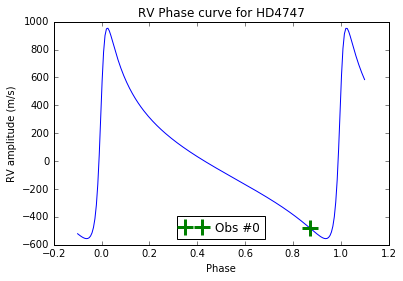


Target HD30501
Radial velocity values of the host star only currently.
Gamma subtracted rv values = [-246.88768364 -122.27137959 -121.21000561 -116.82986697] m/s
RV change over exptime     = [ 0.02066453  0.02107387  0.02107985  0.02110496] m/s
Successive RV Diff         = [ 124.61630405    1.06137397    4.38013865] m/s
Band Lower wl shift        = [  8.81670477e-04   7.50930712e-06   3.09898369e-05] nm
Band Upper wl shift        = [  8.97943747e-04   7.64790866e-06   3.15618263e-05] nm


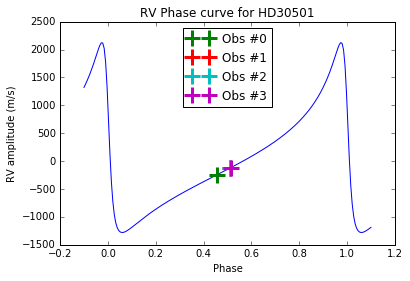


Target HD167665
Radial velocity values of the host star only currently.
Gamma subtracted rv values = [-737.64314371 -737.65153864 -740.16865358] m/s
RV change over exptime     = [-0.0064298  -0.00642839 -0.005981  ] m/s
Successive RV Diff         = [-0.00839493 -2.51711494] m/s
Band Lower wl shift        = [  5.93950062e-08   1.78087930e-05] nm
Band Upper wl shift        = [  6.04914021e-08   1.81374953e-05] nm


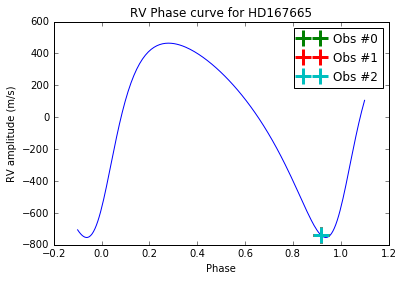


Target HD202206
Radial velocity values of the host star only currently.
Gamma subtracted RV values for b = [ -84.45732826 -103.1758047   -66.71647183] m/s
RV change over exptime for b     = [-0.37629444 -0.39060286 -0.36251123] m/s
Gamma subtracted RV values for c = [ 19.019063    19.13201534  18.90792277] m/s
RV change over exptime for c     = [ 0.00231386  0.00231352  0.00231417] m/s
Combined RV value for triplet    = [-65.43826526 -84.04378935 -47.80854907] m/s
Combined RV Diff between Obs     = [-18.60552409  36.23524029] m/s
Successive RV Diff of b          = [-18.71847643  36.45933287] m/s
Band Lower wl shift of b         = [ 0.00013243  0.00025795] nm
Band Upper wl shift of b         = [ 0.00013488  0.00026271] nm


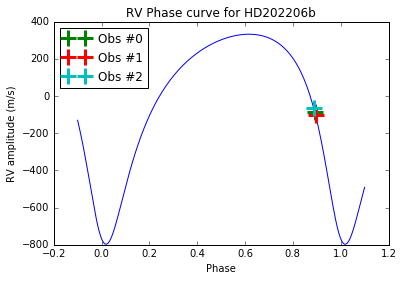

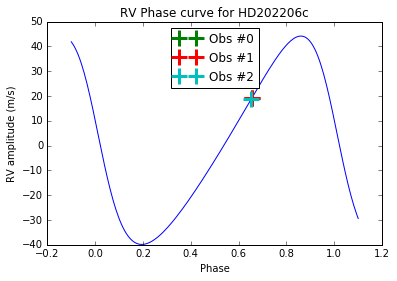


Target HD162020
Radial velocity values of the host star only currently.
Gamma subtracted rv values = [-1258.28312777 -1251.52542645] m/s
RV change over exptime     = [ 5.42134508  5.5697078 ] m/s
Successive RV Diff         = [ 6.75770133] m/s
Band Lower wl shift        = [  4.78112861e-05] nm
Band Upper wl shift        = [  4.86937543e-05] nm


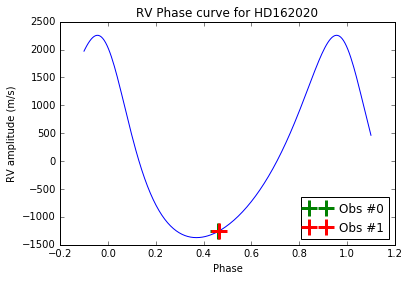


Target HD211847
Radial velocity values of the host star only currently.
Gamma subtracted rv values = [-4.29917535 -6.34781552] m/s
RV change over exptime     = [-0.0056411  -0.00576619] m/s
Successive RV Diff         = [-2.04864017] m/s
Band Lower wl shift        = [  1.44942956e-05] nm
Band Upper wl shift        = [  1.47618211e-05] nm


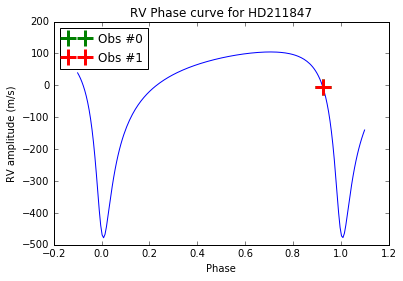


Target HD168443
Radial velocity values of the host star only currently.
Gamma subtracted RV values for b = [ 211.40576895  211.49986415] m/s
RV change over exptime for b     = [ 0.09006337  0.0897528 ] m/s
Gamma subtracted RV values for c = [ 256.45003189  256.46333491] m/s
RV change over exptime for c     = [ 0.01271141  0.01271071] m/s
Combined RV value for triplet    = [ 467.85580083  467.96319906] m/s
Combined RV Diff between Obs     = [ 0.10739823] m/s
Successive RV Diff of b          = [ 0.0940952] m/s
Band Lower wl shift of b         = [  6.65731477e-07] nm
Band Upper wl shift of b         = [  6.78018750e-07] nm


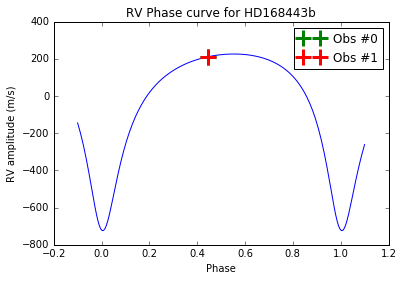

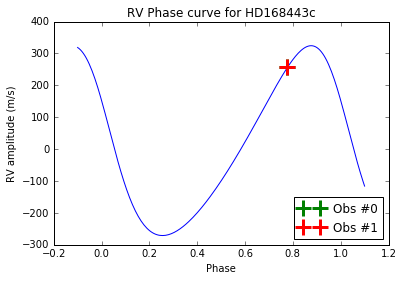

In [6]:
RV_calculations(times_dict, params_dict)

Need to determine how to calculate the expected RV of the planet (not the star) to be able to get proper values out of this. If the planet RV is > 100m/s it would be good for visible detections i think.

I think the RV of planet will be related to mass ratio of Mplanet/Mstar but not sure exactly how...

#### Testing Junk - no need to continue

In [7]:
test_rv_curves(HD30501_times, HD30501_params)
test_rv_curves(HD162020_times, HD162020_params)
test_rv_curves(HD202206_times, HD202206b_params)
test_rv_curves(HD202206_times, HD202206c_params)
test_rv_curves(HD211847_times, HD211847_params)
test_rv_curves(HD4747_times, HD4747_params)
test_rv_curves(HD167665_times, HD167665_params)
test_rv_curves(HD168443_times, HD168443b_params)
test_rv_curves(HD168443_times, HD168443c_params)


Ajplanet RVs = [-246.88768364 -122.27137959 -121.21000561 -116.82986697]
Python RVs   = [-246.88768364 -122.27137959 -121.21000561 -116.82986697]
Ajplanet RVs = [-1258.28312777 -1251.52542645]
Python RVs   = [-1258.28312842 -1251.5254267 ]
Ajplanet RVs = [ -84.45732826 -103.1758047   -66.71647183]
Python RVs   = [ -84.45733491 -103.17581379  -66.71647668]
Ajplanet RVs = [ 19.019063    19.13201534  18.90792277]
Python RVs   = [ 19.01906301  19.13201534  18.90792277]
Ajplanet RVs = [-4.29917535 -6.34781552]
Python RVs   = [-4.29917535 -6.34781552]
Ajplanet RVs = [-482.37561097]
Python RVs   = [-482.37561322]
Ajplanet RVs = [-737.64314371 -737.65153864 -740.16865358]
Python RVs   = [-737.64314434 -737.65153927 -740.16865421]
Ajplanet RVs = [ 211.40576895  211.49986415]
Python RVs   = [ 211.40576895  211.49986415]
Ajplanet RVs = [ 256.45003189  256.46333491]
Python RVs   = [ 256.45003189  256.46333491]


In [8]:
#%timeit aj_rv = pl_rv_array(HD30501_times, *HD30501_params) # *unpacks parameters from list
    
#%timeit py_rv = rv_curve_py(HD30501_times, *HD30501_params) # ajplanet version is 15 X faster 

In [9]:
# Test RV determination 

# Get parameters for star and taget
Red_JD = 2400000
#hd30501
mean_val = 0 # 23.710 # +- 0.017
Period = 2073.6   # +3 - 2.9 days
e = 0.741         # +_ 0.04
K1 = 1703.1       #+- 26  ms^-1
Tau = 53851.5      # +- 3 JD    Note: I think this is tau but I am not sure. 
omega = 70.4 * np.pi/180.     # +- 0.7 deg
values = np.empty_like([1,1,1,1])

for i, ti in enumerate(np.array([2456024.505902, 2456140.887153, 2456141.866329, 2456145.904258]) - Red_JD):
    # Calculate Mean anomaly:
    M_anomaly = meananomaly(ti, Tau, Period)

    # Determine true anomaly from mean anomaly
    true_anomaly = trueanomaly(M_anomaly, e)

    # Now Calculalte the RV of Star
    RV = mean_val + K1 *(np.cos(true_anomaly + omega) + e * np.cos(omega))
    

    print("RV value {0} ms^-1 at time {1} JD*".format( RV ,  ti ))
    values[i] = RV
print(values)
print("Difference in RV between observations ", np.diff(values), " m/s,   --- These values don't match with above")  

RV value [-1257.22750288] ms^-1 at time 56024.505902 JD*
RV value [-1173.18012819] ms^-1 at time 56140.887153 JD*
RV value [-1171.58399899] ms^-1 at time 56141.866329 JD*
RV value [-1164.98042048] ms^-1 at time 56145.904258 JD*
[-1257 -1173 -1171 -1164]
Difference in RV between observations  [84  2  7]  m/s,   --- These values don't match with above
